In [4]:
# -*-coding:utf-8-*-
import os
import glob
import json
import time
import matplotlib
# matplotlib.use('agg')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from mlens.ensemble import SuperLearner
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold
from sklearn.externals import joblib

from scipy.stats import pearsonr, spearmanr, kendalltau
# from kappa_calculator import quadratic_weighted_kappa as qwk
# from kappa_calculator import liaesr_weighted_kappa as lwk

from PIL import Image
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.inception_v3 import preprocess_input

sns.set(style='white', context='notebook', palette='deep')


## Load the data

In [5]:
FLAG_gs = False

dataset = pd.read_csv('./dataset/csv_data/blank_train.csv')
valid_data = pd.read_csv('./dataset/csv_data/blank_valid.csv')

experiment_name = 'first experiment'
dataset.head()

,correct,prob_avg,text_size,ref_size,text_word_size,ref_word_size,flag_short,flag_digit,prob_0,prob_1,...,nb_strip,flag_equal,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7
0,0,0.811444,4,4,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
1,1,0.993514,6,5,1,1,0,0,0,0,...,0,0,0,1,1,1,0,1,0,1
2,0,0.695289,6,7,2,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
3,0,0.969763,24,22,6,3,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,0,0.761748,4,2,1,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,1


In [6]:
dataset.columns.tolist()
print 'DataFrame shape:', dataset.shape

DataFrame shape: (132594, 28)


## Split train and test dataset

In [7]:
# dataset = dataset.drop(['other_avg'],axis=1)
# valid_data = valid_data.drop(['other_avg'],axis=1)

x_train = dataset.iloc[:,1:]
y_train = dataset['correct']

x_valid = valid_data.iloc[:,1:]
y_valid = valid_data['correct']

print 'Features count:', len(x_train.columns.tolist())

Features count: 27


### 1. xgboost classifier

In [8]:
xgb_model = xgb.XGBClassifier().fit(x_train, y_train)

#### 直接预测结果

In [9]:
y_pred = xgb_model.predict(x_valid)
correct_count = 0
for t1, t2 in zip(y_valid, y_pred):
    if t1 == t2:
        correct_count += 1
1.0 * correct_count / len(y_pred)

0.8931792814262873

####  grid search 调参

In [10]:
if FLAG_gs == True:
    xgb1 = xgb.XGBClassifier()
    parameters = {
        'objective':['binary:logistic'],
        'learning_rate': [.01, .03, 0.05, 0.1], #so called `eta` value
        'max_depth': [4, 6, 8],
        'min_child_weight': [4, 6, 8],
        'silent': [1],
        'subsample': [0.7, 0.5, 0.3],
        'colsample_bytree': [0.3, 0.2, 0.1],
        'n_estimators': [100, 200, 300]
    }
    xgb_grid = GridSearchCV(xgb1,
                            parameters,
                            n_jobs = -1,
                            verbose=True)
    xgb_grid.fit(x_train, y_train)
    xgb_best = xgb_grid.best_estimator_

    print xgb_grid.best_score_
    print xgb_grid.best_params_
    
else:
#     xgb_best = xgb_model
    xgb_best = joblib.load('./models/xgb_clf.model')
weights = xgb_best.feature_importances_

# 0.9038040937
# {'colsample_bytree': 0.3, 
#  'silent': 1, 
#  'learning_rate': 0.1, 
#  'min_child_weight': 4, 
#  'n_estimators': 300, 
#  'subsample': 0.7, 
#  'objective': 'binary:logistic', 
#  'max_depth': 8}

# Fitting 3 folds for each of 972 candidates, totalling 2916 fits
# [Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.7s
# [Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.7min
# [Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  9.6min
# [Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 18.1min
# [Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 27.5min
# [Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 37.3min
# [Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 45.5min
# [Parallel(n_jobs=-1)]: Done 2916 out of 2916 | elapsed: 50.4min finished

In [11]:
y_pred = xgb_best.predict(x_valid)
correct_count = 0
for t1, t2 in zip(1.0 *y_valid, y_pred):
    if t1 == t2:
        correct_count += 1
1.0 * correct_count / len(y_pred)


0.9065733506289783

## Feature importances of the model

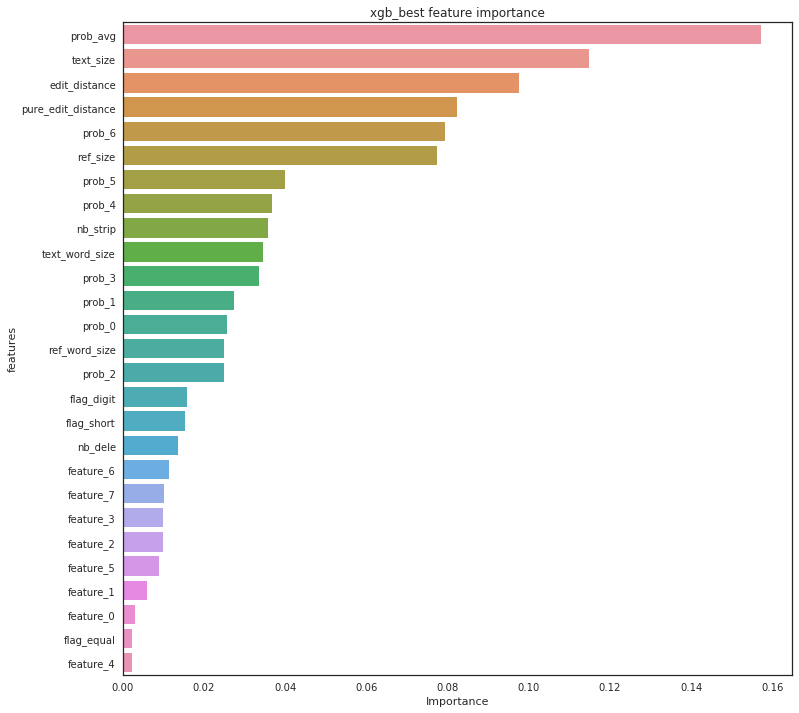

In [12]:
indices = np.argsort(xgb_best.feature_importances_)[::-1]
fig, ax = plt.subplots(figsize=(12,12))
g = sns.barplot(y=x_train.columns[indices], x=xgb_best.feature_importances_[indices], orient='h', ax=ax)

g.set_xlabel('Importance')
g.set_ylabel('features')
g.set_title("xgb_best feature importance")

In [14]:
# joblib.dump(xgb_best, 'models/xgb_clf.model')

##  评分函数

In [15]:
def calc_correl(test_pred, test_origin):
    test_prs, _ = pearsonr(test_pred, test_origin)
    test_spr, _ = spearmanr(test_pred, test_origin)
    test_tau, _ = kendalltau(test_pred, test_origin)
    return test_spr, test_tau


def calc_qwk(test_pred, test_origin, self_low, self_high):
    test_pred_int = np.rint(test_pred).astype('int32')
    test_origin_int = np.rint(test_origin).astype('int32')
    test_qwk = qwk(test_origin_int, test_pred_int, self_low, self_high)
    test_lwk = lwk(test_origin_int, test_pred_int, self_low, self_high)
    return test_qwk,test_lwk

## 2. 模型融合

In [16]:
ensemble = SuperLearner()
# add the first layer
ensemble.add([
    SVC(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    ExtraTreesClassifier(),
    LogisticRegression(),
    xgb.XGBClassifier()
])


SuperLearner(array_check=2, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<type 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<type 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_exce...rer=None)],
   n_jobs=-1, name='group-0', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20, scorer=None, shuffle=False,
       verbose=False)

In [17]:
ensemble.add_meta(xgb.XGBClassifier())

SuperLearner(array_check=2, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<type 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<type 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_exce...rer=None)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20, scorer=None, shuffle=False,
       verbose=False)

In [18]:
ensemble.fit(x_train, y_train)

SuperLearner(array_check=2, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<type 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<type 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_exce...rer=None)],
   n_jobs=-1, name='group-1', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=None, sample_size=20, scorer=None, shuffle=False,
       verbose=False)

In [19]:
y_pred = ensemble.predict(x_valid)
correct_count = 0
for t1, t2 in zip(y_valid, y_pred):
    if t1 == t2:
        correct_count += 1
1.0 * correct_count / len(y_pred)

0.9028628314579625